Load the dataset

In [1]:
import pandas as pd
df = pd.read_csv('Epileptic Seizure Recognition.csv')
df.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


pyTorch Dataset class and Dataloader

In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class EEGDataset(Dataset):
    def __init__(self, mode='train'):
        self.mode = mode
        self._prepare_data()

    def _prepare_data(self):
        # Load and preprocess data
        df = pd.read_csv('Epileptic Seizure Recognition.csv')
        df = df.drop(columns=['Unnamed', 'Unnamed: 0'], errors='ignore')
        
        X = df.drop(columns=['y']).values
        y = (df['y'].values == 1).astype(int)  # Binary classification: seizure vs non-seizure

        # Normalize
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Store based on mode
        if self.mode == 'train':
            self.X = X_train
            self.y = y_train
        elif self.mode == 'test':
            self.X = X_test
            self.y = y_test
        else:
            raise ValueError("Mode must be 'train' or 'test'")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            'Data': torch.tensor(self.X[idx], dtype=torch.float32),
            'label': torch.tensor(self.y[idx], dtype=torch.float32)
        }

# Create datasets for the train and test splits
train_dataset = EEGDataset(mode='train')
test_dataset = EEGDataset(mode='test')

# Create dataloaders for the train and test datasets
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)



Define the network

In [3]:
import torch.nn as nn

class SeizureNet(nn.Module):
    def __init__(self):
        super(SeizureNet, self).__init__()
        self.net = nn.Sequential(
            # Dataset includes 178 features per EEG and this drops it down to 64
            nn.Linear(178, 64),
            nn.LeakyReLU(),
            nn.Dropout(p = 0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            # This layer will return a value from the 64 neurons down to 1, giving us an output of [0,1]
            nn.Linear(64, 1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        return self.net(x)

model = SeizureNet()
#shows first layer matrix
#print(model.net[0].weight) 

Visualize the Neural Network

In [4]:
from torchviz import make_dot

dummy_input = torch.randn(1, 178)
sample = model(dummy_input)
dot = make_dot(sample, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render("BinarySeizureNet_Diagram")
print("Visualization saved as 'SeizureNet_Diagram.png'.")

Visualization saved as 'SeizureNet_Diagram.png'.


Train the model

In [5]:
import torch.optim as optim

train_losses = []
test_losses = []

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs = batch['Data'].float()
        labels = batch['label'].float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
    
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    test_loss = 0.0
    correct = 0 
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['Data'].float()
            labels = batch['label'].float().view(-1, 1)
        
            outputs = model(inputs)
            # Track accuracy in the model
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = correct / total 
            
            loss = criterion(outputs, labels)
            test_loss += loss.detach().item()
    
    test_losses.append(test_loss / len(test_loader))
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Accuracy: {accuracy:.4f}")


Epoch 1/20 | Train Loss: 0.3304 | Test Loss: 0.1201 | Accuracy: 0.9652
Epoch 2/20 | Train Loss: 0.1384 | Test Loss: 0.0849 | Accuracy: 0.9757
Epoch 3/20 | Train Loss: 0.1187 | Test Loss: 0.0791 | Accuracy: 0.9726
Epoch 4/20 | Train Loss: 0.1177 | Test Loss: 0.0799 | Accuracy: 0.9735
Epoch 5/20 | Train Loss: 0.0903 | Test Loss: 0.0777 | Accuracy: 0.9757
Epoch 6/20 | Train Loss: 0.0846 | Test Loss: 0.0654 | Accuracy: 0.9748
Epoch 7/20 | Train Loss: 0.0765 | Test Loss: 0.0660 | Accuracy: 0.9704
Epoch 8/20 | Train Loss: 0.0744 | Test Loss: 0.0692 | Accuracy: 0.9735
Epoch 9/20 | Train Loss: 0.0695 | Test Loss: 0.0643 | Accuracy: 0.9748
Epoch 10/20 | Train Loss: 0.0719 | Test Loss: 0.0582 | Accuracy: 0.9804
Epoch 11/20 | Train Loss: 0.0671 | Test Loss: 0.0596 | Accuracy: 0.9783
Epoch 12/20 | Train Loss: 0.0602 | Test Loss: 0.0573 | Accuracy: 0.9787
Epoch 13/20 | Train Loss: 0.0630 | Test Loss: 0.0594 | Accuracy: 0.9770
Epoch 14/20 | Train Loss: 0.0585 | Test Loss: 0.0571 | Accuracy: 0.9787
E

Evaluate the model

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9864    0.9907    0.9886      1835
         1.0     0.9628    0.9462    0.9544       465

    accuracy                         0.9817      2300
   macro avg     0.9746    0.9685    0.9715      2300
weighted avg     0.9817    0.9817    0.9817      2300



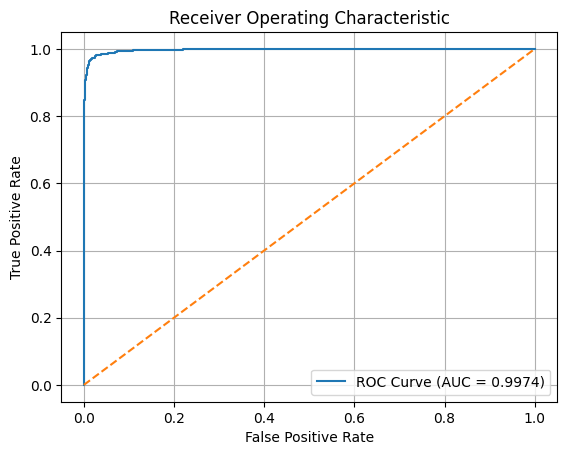

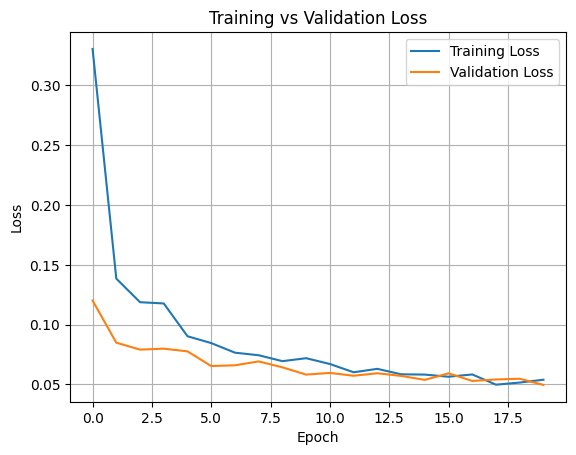

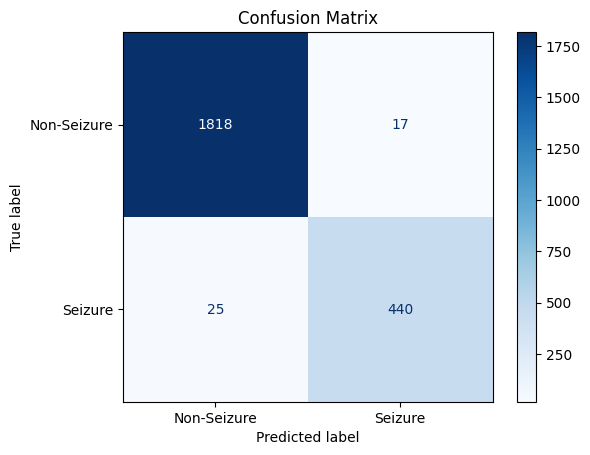

In [6]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader: 
        inputs = batch['Data'].float()
        labels = batch['label'].float().view(-1, 1)

        outputs = model(inputs)
        probs = outputs.cpu().numpy().flatten()
        predicted = (outputs > 0.5).float().cpu().numpy().flatten()
        all_preds.extend(predicted)
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy().flatten())

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

# Training vs Validation Loss Plot
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Seizure", "Seizure"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
